# 下載資料

我生好person, bicycle, car, traffic light的資料了，請至這個google drive連結下載然後傳到你自己的google drive
https://drive.google.com/drive/folders/1ZOpWhs83X1dMMqB9NokK9sn2SDMorpqG?usp=sharing

# 自己準備資料(可先跳過)

如果你想自己弄別的class，或調整small object threshold，請把下面三個檔案換成這個zip檔裡面的檔案
1. models/research/slim內的download_and_convert_data.py
2. 和models/reseach/slim/datasets內的download_and_convert_visualwakewords.py和download_and_convert_visualwakewords_lib.py

zip連結: https://drive.google.com/file/d/1acqxB0kmCENUxBABTjxSLjEETeNe9xe2/view?usp=sharing

可以修改download_and_convert_data.py的small_object_area_threshold和foreground_class_of_interest

當然也可以修改圖片resize的大小(不過model input也要改)

然後在models/research/slim內執行
python download_and_convert_data.py --dataset_name=visualwakewords --dataset_dir=/tmp/visualwakewords

# 後續燒錄進板子(可先跳過)
1. 下載tflite擋下來用xxd -i filename.tflite person_detect_model_data.cc把他轉成C++檔
2. 包成C++檔之後，改掉檔案的頭尾。照抄原本專案裡的person_detect_model_data.cc頭尾就好了。
3. 記得main_function.cc裡面的mutable_op_resolver下，要添加這個net需要的operations(OP必須照字母順序!)，model大時有可能需要改大kTensorArenaSize，不過太大的話也可能compile沒過。一些常見的error如下:

  *   Arena size is too small for all buffers. Needed 176720 but only 137424 was available.
AllocateTensors() failed
  
    -->改大kTensorArenaSize

  *  Didn't find op for builtin opcode 'MAX_POOL_2D' version '2'
Failed to get registration from op code MAX_POOL_2D
Failed starting model allocation.

    -->改mutable_op_resolver的OP

# 訓練模型

執行下一格之後照著指示做，可以讓colab存取google drive內的東西

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf dues_data

下文的/content/drive/My Drive/20210521_vww_data/dues_data_person.zip請修改成自己的file path

目前採用的data:
*   dues_data_person.zip
*   dues_data_car_new.zip (有加額外資料)
*   dues_data_bike_new.zip (包含bike和motorbike、額外資料、coco2017的資料，勉強可train起來)

未採用，但仍可使用的data:
*   dues_data_car.zip
*   dues_data_bicycle.zip (train不起來)
*   dues_data_bike.zip (包含bike和motorbike、額外資料，train不太起來)
*   dues_data_bus.zip (包含bus和truck，train不太起來，而且通常car也會偵測到bus或truck)





In [2]:
!unzip '/content/drive/My Drive/20210521_vww_data/dues_data_person.zip' -d '/content'

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/dues_data/val/object/COCO_val2014_000000430073.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430079.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430125.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430245.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430259.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430265.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430302.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430319.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430341.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430359.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430377.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430380.jpg  
  inflating: /content/dues_data/val/object/COCO_val2014_000000430518.jpg  
  in

我寫了三種model: simple CNN, ResNet-like, MobileNetV2-like(full & small)

2021/7/15 update: 新的mobileNet-like

注意事項:
1. model架構可以亂改，但注意model.summary()的時候output出來的total parameter數量最好不要超過500,000不然一定oversize。我暫時是試在100,000以內了啦
2. ResNet(2 blocks)和MobileNetV2有點train不動，建議用CNN
3. paper的準度是75%，有train到70%就還算不錯
4. 因為資料量大，建議每次train之前kill一下OS，釋放出RAM(執行下方的block)
5. 若每個class資料數量差異大，可以採用weighted classes。請參考: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

每次train之前，建議跑下面這個block以釋放RAM

In [ ]:
import os
os.kill(os.getpid(), 9)

複製檔案到drive用的而已

In [ ]:
!dir
!cp vww_mobile_v5_25.tflite '/content/drive/My Drive/20210521_vww_data/vww_mobile_v5_25_bike_new.tflite'

check_point  drive  dues_data  sample_data  vww_mobile_v5_25.tflite


### 下面幾個儲存格請選一個執行即可

MobileNetV1-like(此為fix RAM error版，可讀更多image但training慢很多)

下一個block為未修正RAM error版

Model: "mobilenetv2_dues"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 96, 96, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 47, 47, 32)        288       
_________________________________________________________________
block_0_depthwise (Depthwise (None, 47, 47, 32)        288       
_________________________________________________________________
block_0_pointwise (Conv2D)   (None, 47, 47, 32)        1024      
_________________________________________________________________
block_1_depthwise (Depthwise (None, 23, 23, 32)        288       
_________________________________________________________________
block_1_pointwise (Conv2D)   (None, 23, 23, 32)        1024      
_________________________________________________________________
block_2_depthwise (Depthwise (None, 23, 23, 32)   

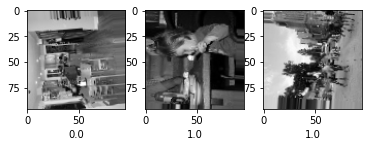

Epoch 1/10
79411/82783 [===========================>..] - ETA: 21s - loss: 0.7096 - accuracy: 0.5605

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
def MobileNetV2_Dues(input_shape=(96,96,1), alpha=1.0, classes=2):
    img_input = layers.Input(shape=input_shape)
    
    # ---build block---
    x = layers.Conv2D(32, kernel_size=3, strides=2, use_bias=False, name='Conv1', activation='relu')(img_input)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=1, block_id=0)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=2)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=5)

    x = layers.Conv2D(128, kernel_size=1, use_bias=False, name='Conv_1', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    # acc: 73% (person) 77% (car)
    # ---build block---
    # x = layers.Conv2D(16, kernel_size=3, strides=2, use_bias=False, name='Conv1', activation='relu')(img_input)

    # x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)
    # x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=1)
    # x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=2)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=3)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=4)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=5)

    # x = layers.Conv2D(128, kernel_size=1, use_bias=False, name='Conv_1', activation='relu')(x)
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    # ---acc = 70/68%---
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name='mobilenetv2_dues')

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = -1

    in_channels = 1
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    # Depthwise
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation='relu',
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)

    # x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation='relu',
                      name=prefix + 'pointwise')(x)

    # if in_channels == pointwise_filters and stride == 1:
    #     return layers.Add(name=prefix + 'add')([inputs, x])
    return x
def dues_preprocess(arr):
    arr = np.transpose(arr, axes=(1,0,2))
    arr = arr - 128.0
    return(arr)
def main_mobileV2_2(epochs, batch_size, save_model_name, rotate):
    # ----create model----
    model = MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=1,
                classes=2)

    model.summary()

    # ----prepare dataset----
    if rotate:
        datagen_train = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            horizontal_flip=True,
            height_shift_range=0.1,
            preprocessing_function=dues_preprocess)
        datagen_test = ImageDataGenerator(
            preprocessing_function=dues_preprocess)
    else:
        datagen_train = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            horizontal_flip=True,
            height_shift_range=0.1,
            )
        datagen_test = ImageDataGenerator(
            )
    
    train_dataset = datagen_train.flow_from_directory(
        directory='/content/dues_data/train',
        # labels='inferred',
        class_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        target_size=(96, 96)
        )
    test_dataset = datagen_test.flow_from_directory(
        directory='/content/dues_data/val',
        # labels='inferred',
        class_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        target_size=(96, 96)
        )
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((3,96,96,1))
    train_label = np.empty((10000,))
    test_data = np.empty((10000,96,96,1))
    test_label = np.empty((10000,))
    for i, (image,label) in enumerate(train_dataset):
        if i < 3: train_data[i] = image
        train_label[i] = label
        # if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        if i==9999:break
    # print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        if i < 10000:  test_data[i] = image
        test_label[i] = label
        # if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==9999:break
    # print('due to RAM restriction of Colab, we only load 10000 test images')
    # print('For bike + motorcycle data, we only use 1000 test images')
    class_weight = {0:1., 1:(10000-np.sum(train_label))/np.sum(train_label)}
    print('class weight: ',class_weight)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(train_data[i,:,:,0], cmap="gray")
        plt.xlabel(train_label[i])
    plt.show()
    
    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    # model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))
    model.fit(train_dataset,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=test_dataset,
              class_weight=class_weight)

    results = model.evaluate(test_dataset, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)

    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 10
batch_size = 128
main_mobileV2_2(epochs, batch_size, "vww_mobile_v5_%d"%epochs, rotate=True)
    

MobileNetV1-like(建議使用)

Model: "mobilenetv2_dues"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 47, 47, 32)        288       
_________________________________________________________________
block_0_depthwise (Depthwise (None, 47, 47, 32)        288       
_________________________________________________________________
block_0_pointwise (Conv2D)   (None, 47, 47, 32)        1024      
_________________________________________________________________
block_1_depthwise (Depthwise (None, 23, 23, 32)        288       
_________________________________________________________________
block_1_pointwise (Conv2D)   (None, 23, 23, 32)        1024      
_________________________________________________________________
block_2_depthwise (Depthwise (None, 23, 23, 32)   

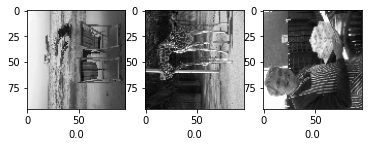

1.6719560929919563e+264
(83816, 96, 96, 1)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
655/655 [==============================] - 72s 61ms/step - loss: 1.1130 - accuracy: 0.5989 - val_loss: nan - val_accuracy: 0.5332
Epoch 2/25
655/655 [==============================] - 40s 61ms/step - loss: 0.9569 - accuracy: 0.7303 - val_loss: nan - val_accuracy: 0.5358
Epoch 3/25
655/655 [==============================] - 40s 60ms/step - loss: 0.8652 - accuracy: 0.7821 - val_loss: nan - val_accuracy: 0.5394
Epoch 4/25
655/655 [==============================] - 40s 61ms/step - loss: 0.8363 - accuracy: 0.7987 - val_loss: nan - val_accuracy: 0.5397
Epoch 5/25
655/655 [==============================] - 40s 61ms/step - loss: 0.8046 - accuracy: 0.8113 - val_loss: nan - val_accuracy: 0.5412
Epoch 6/25
655/655 [==============================] - 40s 60ms/step - loss: 0.7890 - accuracy: 0.8160 - val_loss: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
def MobileNetV2_Dues(input_shape=(96,96,1), alpha=1.0, classes=2):
    img_input = layers.Input(shape=input_shape)
    
    # ---build block---
    x = layers.Conv2D(32, kernel_size=3, strides=2, use_bias=False, name='Conv1', activation='relu')(img_input)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=1, block_id=0)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=2)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=5)

    x = layers.Conv2D(128, kernel_size=1, use_bias=False, name='Conv_1', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    # acc: 73% (person) 77% (car)
    # ---build block---
    # x = layers.Conv2D(16, kernel_size=3, strides=2, use_bias=False, name='Conv1', activation='relu')(img_input)

    # x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)
    # x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=1)
    # x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=2)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=3)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=4)
    # x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=5)

    # x = layers.Conv2D(128, kernel_size=1, use_bias=False, name='Conv_1', activation='relu')(x)
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    # ---acc = 70/68%---
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name='mobilenetv2_dues')

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = -1

    in_channels = 1
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    # Depthwise
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation='relu',
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)

    # x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation='relu',
                      name=prefix + 'pointwise')(x)

    # if in_channels == pointwise_filters and stride == 1:
    #     return layers.Add(name=prefix + 'add')([inputs, x])
    return x
def main_mobileV2_2(epochs, batch_size, save_model_name, rotate):
    # ----create model----
    model = MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=1,
                classes=2)

    model.summary()

    # ----prepare dataset----

    train_dataset = image_dataset_from_directory(
        directory='/content/dues_data/train',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    test_dataset = image_dataset_from_directory(
        directory='/content/dues_data/val',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((train_size,96,96,1))
    train_label = np.empty((train_size,))
    test_data = np.empty((10000,96,96,1))
    test_label = np.empty((10000,))
    for i, (image,label) in enumerate(train_dataset):
        train_data[i] = image
        train_label[i] = label
        if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        # if i==4999:break
    print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        test_data[i] = image
        test_label[i] = label
        if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==999:break
    # print('due to RAM restriction of Colab, we only load 10000 test images')
    print('For bike + motorcycle data, we only use 1000 test images')
    class_weight = {0:1., 1:(train_size-np.sum(train_label))/np.sum(train_label)}
    print('class weight: ',class_weight)
    if rotate:
      train_data = np.transpose(train_data, axes=(0,2,1,3))
      test_data = np.transpose(test_data, axes=(0,2,1,3))
    print(train_data.shape)
    #train_data = np.average(train_data,axis=3)
    #test_data = np.average(test_data,axis=3)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(train_data[i,:,:,0], cmap="gray")
        plt.xlabel(train_label[i])
    plt.show()
    
    #train_data = np.expand_dims(train_data.astype(np.float32) - 128.0, axis=-1)
    #cifar (50000, 32, 32, 3, 1)
    #mnist(60000, 28, 28, 1)
    #test_data = np.expand_dims(test_data.astype(np.float32) - 128.0, axis=-1)
    train_data = train_data.astype(np.float32) - 128.0
    test_data = test_data.astype(np.float32) - 128.0
    print(np.sum(test_label))
    if rotate:
      datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        vertical_flip=True,
        height_shift_range=0.1)
    else:
      datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        horizontal_flip=True,
        height_shift_range=0.1)
    datagen.fit(train_data)
    print(train_data.shape)
    
    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    # model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))
    model.fit(train_data, train_label,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_data, test_label),
              class_weight=class_weight)

    results = model.evaluate(test_data, test_label, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)

    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 25
batch_size = 128
main_mobileV2_2(epochs, batch_size, "vww_mobile_v5_%d"%epochs, rotate=True)
    

Simple CNN(後來有把一些CONV換成depthwise)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2

def main_cnn(epochs, batch_size, save_model_name, rotate):

    # ----create model----
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(input_shape=(96, 96, 1), filters=8, kernel_size=[3, 3], padding='valid',
                                     activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=[3, 3], padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    model.add(tf.keras.layers.DepthwiseConv2D(kernel_size=3, activation='relu', use_bias=False))
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[1, 1], padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    model.add(tf.keras.layers.DepthwiseConv2D(kernel_size=3, activation='relu', use_bias=False))
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[1, 1], padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    model.summary()
    # val accu: 71%
    # ----create model----
    # model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Conv2D(input_shape=(96, 96, 1), filters=16, kernel_size=[3, 3], padding='valid',
    #                                  activation=tf.nn.relu))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(32, activation='relu'))
    # model.add(tf.keras.layers.Dense(2, activation='softmax'))

    # model.summary()
    # val accu: 71%
    # ----create model----
    # model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Conv2D(input_shape=(96, 96, 1), filters=16, kernel_size=[3, 3], padding='valid',
    #                                  activation=tf.nn.relu))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2))
    # model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding='valid', activation='relu'))
    # model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(32, activation='relu'))
    # model.add(tf.keras.layers.Dense(2, activation='softmax'))

    # model.summary()
    # val accu: 66%    
    # ----prepare dataset----

    train_dataset = image_dataset_from_directory(
        directory='/content/dues_data/train',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    test_dataset = image_dataset_from_directory(
        directory='/content/dues_data/val',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((train_size,96,96,1))
    train_label = np.empty((train_size,))
    test_data = np.empty((10000,96,96,1))
    test_label = np.empty((10000,))
    for i, (image,label) in enumerate(train_dataset):
        train_data[i] = image
        train_label[i] = label
        if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        # if i==4999:break
    print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        test_data[i] = image
        test_label[i] = label
        if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==9999:break
    print('due to RAM restriction of Colab, we only load 10000 test images')
    class_weight = {0:1., 1:(train_size-np.sum(train_label))/np.sum(train_label)}
    print('class weight: ',class_weight)
    if rotate:
      train_data = np.transpose(train_data, axes=(0,2,1,3))
      test_data = np.transpose(test_data, axes=(0,2,1,3))
    print(train_data.shape)
    #train_data = np.average(train_data,axis=3)
    #test_data = np.average(test_data,axis=3)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(train_data[i,:,:,0], cmap="gray")
        plt.xlabel(train_label[i])
    plt.show()
    
    #train_data = np.expand_dims(train_data.astype(np.float32) - 128.0, axis=-1)
    #cifar (50000, 32, 32, 3, 1)
    #mnist(60000, 28, 28, 1)
    #test_data = np.expand_dims(test_data.astype(np.float32) - 128.0, axis=-1)
    train_data = train_data.astype(np.float32) - 128.0
    test_data = test_data.astype(np.float32) - 128.0
    print(np.sum(test_label))
    if rotate:
      datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        vertical_flip=True,
        height_shift_range=0.1)
    else:
      datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        vertical_fliphorizontal_flip=True,
        height_shift_range=0.1)
    datagen.fit(train_data)
    print(train_data.shape)

    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    # model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))
    model.fit(train_data, train_label,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_data, test_label),
              class_weight=class_weight)

    results = model.evaluate(test_data, test_label, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        # for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(1000):    
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
        
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)
    print('model saved to ',save_model_name+".tflite")
    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 15
batch_size = 128
main_cnn(epochs, batch_size, "vww_cnn_v4_%d"%epochs, rotate=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 8)         80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 94, 94, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 8)         0         
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 45, 45, 8)         72        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 16)        144       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 16)       

FileNotFoundError: ignored

ResNet-like

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
def Conv2D_BN(inputs,filter,kernel,padding,stride):
    outputs = keras.layers.Conv2D(filters=filter,kernel_size=kernel,padding=padding,strides=stride,activation='relu')(inputs)
    outputs = keras.layers.BatchNormalization()(outputs)
    return outputs

def residual_block(inputs,filter,stride,whether_identity_change=False):
    x = Conv2D_BN(inputs, filter[0], kernel=(1,1), padding='same', stride=stride) 
    x = Conv2D_BN(x, filter[1], kernel=(3,3), padding='same', stride=1)
    x = Conv2D_BN(x, filter[2] ,kernel=(1,1), padding='same', stride=1)

    if whether_identity_change:
        identity = Conv2D_BN(inputs, filter[2], kernel=(1,1), padding='same', stride=stride)
        x = keras.layers.add([x,identity])
        return x
    else:
        x = keras.layers.add([x,inputs])
        return x
def ResNet():
    inputs = keras.Input(shape=(96,96,1))
    x = Conv2D_BN(inputs,16,(3,3),'same',2)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')(x)
    x = residual_block(x,[16,16,16],1)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    x = residual_block(x,[16,16,16],1)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32,activation='relu')(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs=inputs,outputs=x)
    #model.summary()
    return model

def main_res(epochs, batch_size, save_model_name):
    # ----create model----
    model = ResNet()

    model.summary()

    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    # ----prepare dataset----

    train_dataset = image_dataset_from_directory(
        directory='/content/dues_data/train',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    test_dataset = image_dataset_from_directory(
        directory='/content/dues_data/val',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((train_size,96,96,1))
    train_label = np.empty((train_size,))
    test_data = np.empty((5000,96,96,1))
    test_label = np.empty((5000,))
    for i, (image,label) in enumerate(train_dataset):
        train_data[i] = image
        train_label[i] = label
        if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        # if i==4999:break
    print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        test_data[i] = image
        test_label[i] = label
        if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==4999:break
    print('due to RAM restriction of Colab, we only load 5000 test images')

    #train_data = np.average(train_data,axis=3)
    #test_data = np.average(test_data,axis=3)
    # for i in range(3):
    #     plt.subplot(1, 3, i + 1)
    #     plt.imshow(train_data[i], cmap="gray")
    #     plt.xlabel(train_label[i])
    # plt.show()
    
    #train_data = np.expand_dims(train_data.astype(np.float32) - 128.0, axis=-1)
    #cifar (50000, 32, 32, 3, 1)
    #mnist(60000, 28, 28, 1)
    #test_data = np.expand_dims(test_data.astype(np.float32) - 128.0, axis=-1)
    train_data = train_data.astype(np.float32) - 128.0
    test_data = test_data.astype(np.float32) - 128.0

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        horizontal_flip=True,
        height_shift_range=0.1)
    datagen.fit(train_data)
    print(train_data.shape)

    

    model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))

    results = model.evaluate(test_data, test_label, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        # for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(1000):    
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
        
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)
    print('model saved to ',save_model_name+".tflite")
    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 10
batch_size = 128
main_res(epochs, batch_size, "vww_res_%d"%epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

MobileNet-like(架構沒調好train不動)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
def MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=1.0,
                classes=2):
    # input_shape = (96,96,1)
    img_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(img_input)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels

    x = layers.Conv2D(320,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.ReLU(6., name='out_relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax',
                  use_bias=True, name='Logits')(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name='mobilenetv2_dues')

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = -1

    in_channels = 1
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=((2,2),(2,2)),
                                 name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x
def main_mobileV2(epochs, batch_size, save_model_name):
    # ----create model----
    model = MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=0.35,
                classes=2)

    model.summary()

    # ----prepare dataset----

    train_dataset = image_dataset_from_directory(
        directory='/content/dues_data/train',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    test_dataset = image_dataset_from_directory(
        directory='/content/dues_data/val',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((train_size,96,96,1))
    train_label = np.empty((train_size,))
    test_data = np.empty((5000,96,96,1))
    test_label = np.empty((5000,))
    for i, (image,label) in enumerate(train_dataset):
        train_data[i] = image
        train_label[i] = label
        if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        # if i==4999:break
    print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        test_data[i] = image
        test_label[i] = label
        if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==4999:break
    print('due to RAM restriction of Colab, we only load 5000 test images')

    #train_data = np.expand_dims(train_data.astype(np.float32) - 128.0, axis=-1)
    #cifar (50000, 32, 32, 3, 1)
    #mnist(60000, 28, 28, 1)
    #test_data = np.expand_dims(test_data.astype(np.float32) - 128.0, axis=-1)
    train_data = train_data.astype(np.float32) - 128.0
    test_data = test_data.astype(np.float32) - 128.0


    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        horizontal_flip=True,
        height_shift_range=0.1)
    datagen.fit(train_data)
    print(train_data.shape)

    
    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))

    results = model.evaluate(test_data, test_label, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)

    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 10
batch_size = 128
main_mobileV2(epochs, batch_size, "vww__mobile_full_%d"%epochs)
    

另一個MobileNet-like(架構沒調好train不動)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
def MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=1.0,
                classes=2):
    # input_shape = (96,96,1)
    img_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(img_input)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)



    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels

    x = layers.Conv2D(128,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.ReLU(6., name='out_relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax',
                  use_bias=True, name='Logits')(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name='mobilenetv2_dues')

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = -1

    in_channels = 1
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=((2,2),(2,2)),
                                 name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x
def main_mobileV2(epochs, batch_size, save_model_name):
    # ----create model----
    model = MobileNetV2_Dues(input_shape=(96,96,1),
                alpha=0.35,
                classes=2)

    model.summary()

    # ----prepare dataset----

    train_dataset = image_dataset_from_directory(
        directory='/content/dues_data/train',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    test_dataset = image_dataset_from_directory(
        directory='/content/dues_data/val',
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=1,
        image_size=(96, 96))
    train_size = len(train_dataset)
    test_size = len(test_dataset)
    print('there are %d train images and %d test images.'%(train_size,test_size))
    train_data = np.empty((train_size,96,96,1))
    train_label = np.empty((train_size,))
    test_data = np.empty((5000,96,96,1))
    test_label = np.empty((5000,))
    for i, (image,label) in enumerate(train_dataset):
        train_data[i] = image
        train_label[i] = label
        if i%5000==0: print('%d/%d train images loaded'%(i,train_size))
        # if i==4999:break
    print('%d train images loaded'%train_size)
    for i, (image,label) in enumerate(test_dataset):
        test_data[i] = image
        test_label[i] = label
        if i%5000==0: print('%d/%d test images loaded'%(i,test_size))
        if i==4999:break
    print('due to RAM restriction of Colab, we only load 5000 test images')

    #train_data = np.expand_dims(train_data.astype(np.float32) - 128.0, axis=-1)
    #cifar (50000, 32, 32, 3, 1)
    #mnist(60000, 28, 28, 1)
    #test_data = np.expand_dims(test_data.astype(np.float32) - 128.0, axis=-1)
    train_data = train_data.astype(np.float32) - 128.0
    test_data = test_data.astype(np.float32) - 128.0


    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        horizontal_flip=True,
        height_shift_range=0.1)
    datagen.fit(train_data)
    print(train_data.shape)

    
    # ----train model----

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_label))

    results = model.evaluate(test_data, test_label, batch_size=batch_size)

    tf.saved_model.save(model, os.path.join("check_point", save_model_name))

    # ----quantize model----

    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(test_data).batch(1).take(5000):
            # Model has only one input so each data point has one element.
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join("check_point", save_model_name))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()

    with open(os.path.join(os.getcwd(), save_model_name+".tflite"), mode='wb') as f:
        f.write(tflite_model_quant)

    # ----test with quantize model----

    interpreter = tf.lite.Interpreter(model_path=save_model_name+".tflite")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scales = output_details[0]["quantization_parameters"]["scales"][0]
    zero_points = output_details[0]["quantization_parameters"]["zero_points"][0]
    interpreter.allocate_tensors()

    test_dataloader = tf.data.Dataset.from_tensor_slices((test_data[:1000], test_label[:1000]))
    test_dataloader = test_dataloader.batch(batch_size=1)

    quantized_test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

    for test_data, test_label in test_dataloader:
        interpreter.set_tensor(input_details[0]["index"], tf.cast(test_data, dtype=tf.int8))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        output = (output + (-zero_points)) * scales

        predictions = tf.reshape(output, shape=(output.shape[0], 2))
        quantized_test_acc.update_state(y_true=test_label, y_pred=predictions)

    print("Before quantiz accuracy: {}%".format(results[1] * 100))
    print("Quantized test accuracy: {}%".format(quantized_test_acc.result() * 100))
    print("loss acc : {}%".format((results[1] - quantized_test_acc.result()) * 100))
epochs = 10
batch_size = 128
main_mobileV2(epochs, batch_size, "vww__mobile_small_%d"%epochs)
    

Model: "mobilenetv2_dues"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 47, 47, 32)        288       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 47, 47, 32)        0         
_________________________________________________________________
expanded_conv_depthwise (Dep (None, 47, 47, 32)        288       
_________________________________________________________________
expanded_conv_depthwise_relu (None, 47, 47, 32)        0         
_________________________________________________________________
expanded_conv_project (Conv2 (None, 47, 47, 8)         256       
_________________________________________________________________
block_1_expand (Conv2D)      (None, 47, 47, 6)    

KeyboardInterrupt: ignored